# Non-dimensionalization of The CBC Condition

Comete-Bellot and Corrsin performed a [turbulent experiment](https://acoustique.ec-lyon.fr/publi/comte-bellot_jfm71.pdf) at 1971. The recorded data have been to validate numerical methods in many papers.

The 5.08cm grid setup is used in this file. The collected kinetic energy at different wavelength are listed as (also see table 3 of their paper)

| $k, cm^{-1}$ | $\frac{tU_0}{M}=42$ | $\frac{tU_0}{M}=98$ | $\frac{tU_0}{M}=171$ |
|--------------|---------------------|---------------------|----------------------|
| 0.15         | -                   | -                   | 49.7                 |
| 0.20         | 129                 | 106                 | 92                   |
| 0.25         | 230                 | 196                 | 120                  |
| 0.30         | 322                 | 195                 | 125                  |
| 0.40         | 435                 | 202                 | 98                   |
| 0.50         | 457                 | 168                 | 81.5                 |
| 0.70         | 380                 | 127                 | 60.2                 |
| 1.00         | 270                 | 79.2                | 39.4                 |
| 1.50         | 168                 | 47.8                | 24.1                 |
| 2.00         | 120                 | 34.6                | 16.5                 |
| 2.50         | 89                  | 28.6                | 12.5                 |
| 3.00         | 70.3                | 23.1                | 9.12                 |
| 4.00         | 47                  | 14.3                | 5.62                 |
| 6.00         | 24.7                | 5.95                | 1.69                 |
| 8.00         | 12.6                | 2.23                | 0.52                 |
| 10.00        | 7.42                | 0.9                 | 0.161                |
| 12.50        | 3.96                | 0.363               | 0.052                |
| 15.00        | 2.33                | 0.162               | 0.0141               |
| 17.50        | 1.34                | 0.066               | -                    |
| 20.00        | 0.8                 | 0.033               | -                    | 

where $U_0=10m/s$ and $M=5.08cm$. Hence, we could compute the end time as 0.21336, 0.49784 and 0.86868, respectively. The Taylor microscale Reynolds numbers $Re_{\lambda} = u^`\lambda/\nu$ are 71.6, 65.1, 60.7, respectively. The grid Reynolds number of the experiment is $Re=34000$, then we have the dynamic viscosity about 0.000015.

In the simulation, the velocity field should be initialized based on the energy spectra at $\frac{tU_0}{M}=42$, and then is evolved to $\frac{tU_0}{M}=98$ and $\frac{tU_0}{M}=171$. If we set the start time at $\frac{tU_0}{M}=42$ as 0.0, the end time for next two state should be 0.28448 and 0.65532, respectively.

To simulate this isotropic flow in a $(2\pi)^3$ domain, the length, velocity and time should be scaled by the reference length $L_{ref}=10.8M/2\pi$, the reference velocity $U_{ref}=\sqrt{3/2}*22.2cm/s$ and the reference time $t_{ref}=L_{ref}/U_{ref}$. 

Now we import numpy and define the reference values (pay attention to the unit):

In [1]:
import numpy as np

u_ref = np.sqrt(3/2) * 22.2
l_ref = 10.8 * 5.08 / 2 / np.pi
t_ref = l_ref / u_ref
ek_ref = l_ref**3 / t_ref**2

The wavenumber, kinetic energy should be non-dimensionalized with the reference values. Then we could plot them in log scale

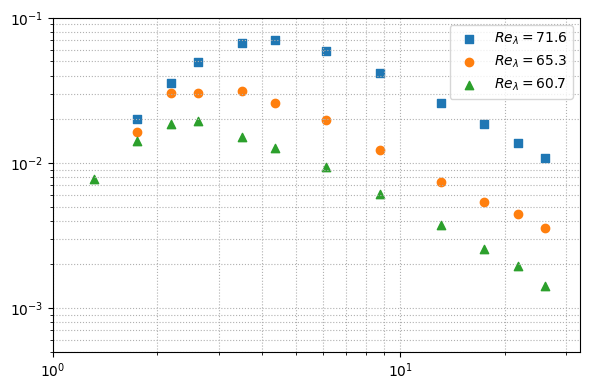

In [2]:
import matplotlib.pyplot as plt

k = np.array([0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5, 3, 4, 6, 8, 10, 12.5, 15, 17.5, 20]) * l_ref
# for tU0/M = 42, k starts from 0.2
E_k42 = np.array([129, 230, 322, 435, 457, 380, 270, 168, 120, 89, 70.3, 47, 24.7, 12.6, 7.42, 3.96, 2.33, 1.34, 0.8]) / ek_ref
# for tU0/M = 98, k starts from 0.2
E_k98 = np.array([106, 196, 195, 202, 168, 127, 79.2, 47.8, 34.6, 28.6, 23.1, 14.3, 5.95, 2.23, 0.9, 0.363, 0.162, 0.066, 0.033]) / ek_ref
# for tU0/M = 171, k starts from 0.15
E_k171 = np.array([49.7, 92, 120, 125, 98, 81.5, 60.2, 39.4, 24.1, 16.5, 12.5, 9.12, 5.62, 1.69, 0.52, 0.161, 0.052, 0.0141]) / ek_ref
plt.figure(dpi=100)
plt.scatter(k[1:14], E_k42[:13], marker="s", label=r"$Re_\lambda=71.6$")
plt.scatter(k[1:14], E_k98[:13], marker="o", label=r"$Re_\lambda=65.3$")
plt.scatter(k[:13], E_k171[:13], marker="^", label=r"$Re_\lambda=60.7$")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.ylim(0.0005, 0.1)
plt.xlim(1, 33)
plt.grid(which="both", linestyle=":")
plt.tight_layout()

The end time should also be rescaled as

In [3]:
end_t1 = 0.21336
end_t2 = 0.49784
end_t3 = 0.86868

evol_end_time1 = (end_t2 - end_t1) / t_ref
evol_end_time2 = (end_t3 - end_t1) / t_ref
evol_end_time1, evol_end_time2

(0.885814416031794, 2.0405367797875256)

Since the energy are not evenly distributed and the corresponding wavenumber is not an integer, we need to reconstruct the energy at integer wavenumber to build the reference energy spectra. The polynomial interpolation are normally used. Here we use the Gaussian process (GP) to find the missed energy.

Note that we build the regression model at log scale, and the input should be normalized for GP.

In [4]:
import gpytorch
import torch

x = np.log(k[1:])
y = np.log(E_k42)
normalized_x = x / (x.max() - x.min())
train_x = torch.tensor(normalized_x.reshape(-1, 1))
train_y = torch.tensor(y)


class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [5]:
training_iter = 100

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/100 - Loss: 3.273   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 3.086   lengthscale: 0.644   noise: 0.744
Iter 3/100 - Loss: 2.922   lengthscale: 0.599   noise: 0.797
Iter 4/100 - Loss: 2.777   lengthscale: 0.556   noise: 0.850
Iter 5/100 - Loss: 2.650   lengthscale: 0.516   noise: 0.902
Iter 6/100 - Loss: 2.538   lengthscale: 0.479   noise: 0.949
Iter 7/100 - Loss: 2.440   lengthscale: 0.445   noise: 0.991
Iter 8/100 - Loss: 2.353   lengthscale: 0.416   noise: 1.026
Iter 9/100 - Loss: 2.277   lengthscale: 0.392   noise: 1.051
Iter 10/100 - Loss: 2.207   lengthscale: 0.375   noise: 1.066
Iter 11/100 - Loss: 2.142   lengthscale: 0.366   noise: 1.073
Iter 12/100 - Loss: 2.081   lengthscale: 0.363   noise: 1.070
Iter 13/100 - Loss: 2.024   lengthscale: 0.364   noise: 1.060
Iter 14/100 - Loss: 1.969   lengthscale: 0.369   noise: 1.043
Iter 15/100 - Loss: 1.918   lengthscale: 0.374   noise: 1.020
Iter 16/100 - Loss: 1.870   lengthscale: 0.380   noise: 0.991
Iter 17/100 - Los

We predict the output for wavenumber from 1 to 55 which corresponds to the maximum wavenumber in our setting.

In [6]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1.3, 51).double()
    observed_pred = likelihood(model(test_x))
    
k_integer = torch.arange(1, 56).reshape(-1, 1).double()
log_k = torch.log(k_integer) / (x.max() - x.min())
# torch.cat([0], log_k)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_k = likelihood(model(log_k))

Back to linear space, we plot our results in log scale.

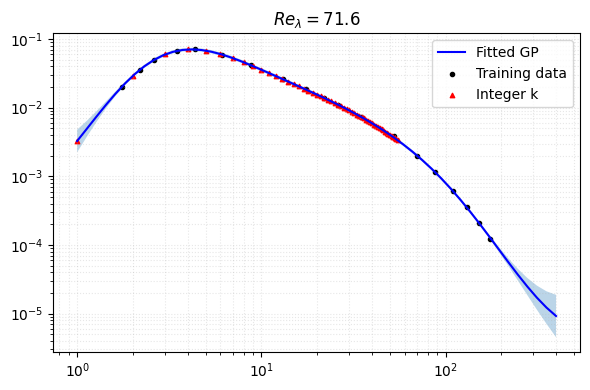

In [9]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, dpi=100)
    
    raw_train_x = np.exp(train_x.numpy() * (x.max() - x.min()))
    raw_test_x  = np.exp(test_x.numpy() * (x.max() - x.min()))
    raw_integer_k = np.exp(log_k.numpy() * (x.max() - x.min()))
    
    lower, upper = observed_pred.confidence_region()
    # plot the fitted Gaussian and training data
    ax.scatter(raw_train_x, np.exp(train_y.numpy()), marker=".", color="black", label="Training data")
    ax.plot(raw_test_x, np.exp(observed_pred.mean.numpy()), 'b', label="Fitted GP")
    ax.fill_between(raw_test_x, np.exp(lower.numpy()), np.exp(upper.numpy()), alpha=0.3)
    
    # plot predicted value with integer k
    ax.scatter(raw_integer_k, np.exp(observed_pred_k.mean.numpy()), marker="^", s=10, color="red", label="Integer k")
    
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend()
    ax.grid(which="both", linestyle=":", alpha=0.3)
    ax.set_title(r"$Re_\lambda=71.6$")
    plt.tight_layout()

Now we have the energy at wavenumber from 1 to 55. Note that wavenumber 0 has zero energy

In [8]:
np.exp(observed_pred_k.mean.numpy())

array([0.00327365, 0.02886479, 0.05957186, 0.07045104, 0.0677236 ,
       0.0604232 , 0.05272768, 0.04595604, 0.04032604, 0.03571568,
       0.03193417, 0.02880539, 0.02618687, 0.02396867, 0.02206723,
       0.02041924, 0.01897645, 0.0177018 , 0.01656655, 0.01554815,
       0.01462875, 0.013794  , 0.01303231, 0.01233418, 0.01169175,
       0.01109847, 0.01054883, 0.01003816, 0.00956245, 0.00911827,
       0.00870262, 0.00831291, 0.00794686, 0.00760245, 0.00727791,
       0.00697166, 0.00668227, 0.00640849, 0.00614917, 0.00590328,
       0.00566988, 0.00544815, 0.00523729, 0.00503661, 0.00484547,
       0.00466328, 0.00448949, 0.0043236 , 0.00416515, 0.00401373,
       0.00386893, 0.00373039, 0.00359777, 0.00347075, 0.00334904])